In [1]:
%load_ext tikzmagic
%matplotlib inline

# 모형진단과 다항회귀

지금까지는 예측값이 직선형태로 나오는 선형(linear)회귀분석을 이용하여 종속변수를 예측하였다. 그러나 현실의 데이터는 이러한 선형회귀분석 모형을 따르지 않을 수도 있다. 이 절에서는 선형회귀분석에서 사용한 모형이나 가정이 적정한지 아닌지를 확인하고 그렇지 않은 이런 경우에 어떤 방식으로 모형을 수정해야하는지를 공부한다. 우리가 사용한 모형과 가정이 적정한지를 검토하는 작업을 <b>모형진단(model diagnosis)</b>이라고 한다.

## 부분회귀

독립변수가 하나뿐인 경우에는 x축을 독립변수로, y축을 종속변수로 하는 스캐터플롯과 예측값 직선을 이용하여 회귀분석의 결과를 시각적으로 표시하여 독립변수와 종속변수의 관계 및 회귀 성능을 유추할 수 있었다. 하지만 독립변수가 두개 이상인 경우에 이러한 방식을 사용하면 다른 독립변수의 영향으로 예측값이 직선으로 나오지 않기 때문에 이러한 시각화 방식을 사용하기 어렵다. 

보스턴 집값 데이터를 lstat과 rm 두가지 독립변수로 선형회귀분석한 결과를 이용하여 예를 들어보자. 

In [2]:
import statsmodels.api as sm

boston = sm.datasets.get_rdataset("Boston", "MASS").data
model = sm.OLS.from_formula("medv ~ scale(lstat) + scale(rm)", boston)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     444.3
Date:                Wed, 03 Aug 2022   Prob (F-statistic):          7.01e-112
Time:                        15:17:40   Log-Likelihood:                -1582.8
No. Observations:                 506   AIC:                             3172.
Df Residuals:                     503   BIC:                             3184.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.5328      0.246     91.487   

예를 들어 x축을 두번째 독립변수인 rm으로, y축을 종속변수인 medv로 놓고 2차원 평면에 데이터(o)와 예측값(x)을 그리면 다음과 같다. 이 플롯으로는 독립변수 lstat에 대한 모형의 가중치(기울기)를 알 수가 없다.

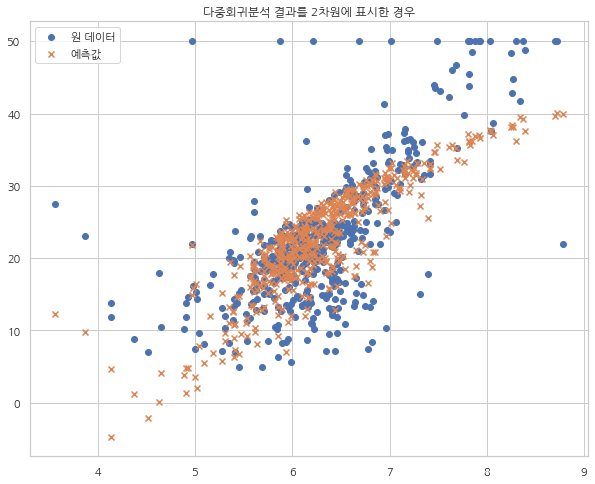

In [3]:
x = boston.rm
y = boston.medv
y_hat = result.fittedvalues

plt.figure(figsize=(10, 8))
plt.scatter(x, y, marker="o", label="원 데이터")
plt.scatter(x, y_hat, marker="x", label="예측값")
plt.legend()
plt.title("다중회귀분석 결과를 2차원에 표시한 경우")
plt.show()

statsmodels 패키지가 제공하는 `plot_fit` 함수를 사용하면 좀 더 쉽게 그릴 수 있다. 이 때는 각 데이터에 대한 개별 잔차의 표준편차를 바(bar)로 표시해 준다. 개별 잔차의 표준편차보다도 바깥에 있는 데이터는 아웃라이어일 가능성이 높다.

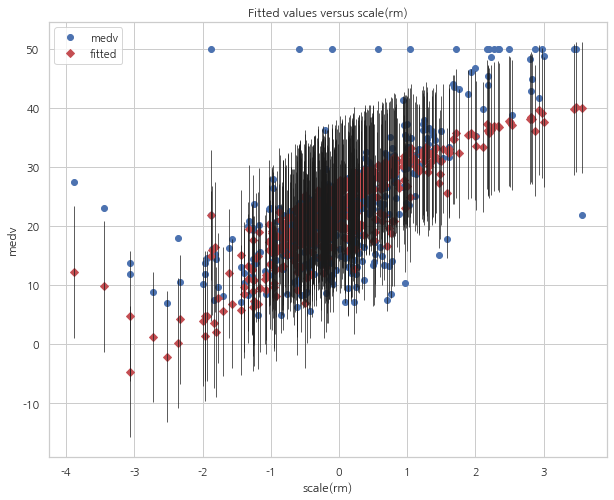

In [4]:
f, ax = plt.subplots(figsize=(10, 8))
sm.graphics.plot_fit(result, "scale(rm)", ax=ax)
plt.show()

이러한 경우에 사용할 수 있는 방법이 CCPR(component-plus-residual) 및 부분회귀(partial-regression) 시각화 방법이다. 

<b>CCPR(component-plus-residual)</b> 시각화는 2차원 평면에서 x축을 특정한 독립변수 하나, 예를 들어 $k$번째 독립변수인 $x_k$ 값으로 놓고 y축은 다음 데이터를 이용한다.

* 원 데이터의 y축 값으로는 

$$
\hat{y}_k = w_k x_k + e
$$

를 사용한다. 여기에서 $e$는 전체 독립변수를 사용한 다중선형회귀분석 결과에서 나온 잔차다.

* 예측 데이터의 y축 값으로는 선형회귀 예측값에서 $x_k$과 관련된 부분인

$$
\hat{y}_k = w_k x_k 
$$

만 사용한다. 이렇게 하면 다중선형회귀분석의 결과로 나온 가중치의 값(기울기)도 표시하고 그에 따른 오차도 표시된다.

statsmodels 패키지는 CCPR 시각화를 위한 `plot_ccpr` 함수를 제공한다. 사용법은 다음과 같다.

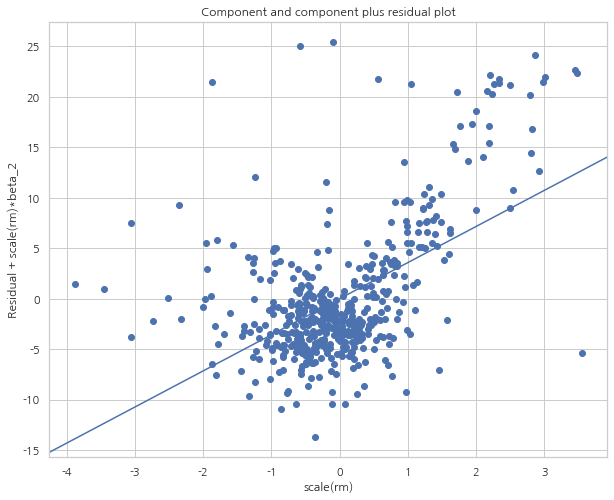

In [5]:
f, ax = plt.subplots(figsize=(10, 8))
sm.graphics.plot_ccpr(result, "scale(rm)", ax=ax)
plt.show()

또다른 방법은 부분회귀 방법을 사용하는 것이다. <b>부분회귀(partial regression)</b>는 특정한 독립변수 $x_k$과 종속변수 $y$만의 관계만 분석하고 $x_k$를 제외한 다른 독립변수의 영향은 제거하는 방법이다. 부분회귀를 하려면 원리적으로 다음과 같이 3번의 회귀분석을 해야 한다.

1. 특정한 독립변수 $x_k$를 제외한 나머지 독립변수들로 종속변수 $y$를 선형회귀분석하여 잔차 $y_k^{\ast}$를 구한다.
1. 특정한 독립변수 $x_k$를 제외한 나머지 독립변수들로 특정한 독립변수 $x_k$를 선형회귀분석하여 잔차 $x_k^{\ast}$를 구한다.
1. 잔차 $x_k^{\ast}$를 독립변수로, 잔차 $y_k^{\ast}$를 종속변수로 하여 선형회귀분석한다.

예를 들어 첫번째 독립변수인 $x_1$과 종속변수 $y$만의 관계만 구하고 싶은 경우, 1번 작업을 통해 $x_1$을 제외한 $x_2, x_3, \ldots, x_k$만 사용하여 선형회귀분석을 한다. 그러면 이 때 나오는 잔차 $y_k^{\ast}$는 독립변수 $x_2, x_3, \ldots, x_k$로는 도저히 예측할 수 없는 부분만 남는다. 그리고 2번 작업을 통해 $x_1$ 정보 중 $x_2, x_3, \ldots, x_k$와 상관관계가 있는 값을 제거하여 순수한 $x_1$ 정보만을 남긴다. 마지막으로 3번 작업을 통해 순수한 $x_1$ 정보와 $x_2, x_3, \ldots, x_k$로 예측 불가능한 정보 사이의 관계를 구하는 것이다. 이러한 방식으로 부분회귀를 하면 3번 작업에서 나온 가중치 $\hat{w}_k$가 모든 독립변수를 사용하였을 때 나오는 가중치 $\hat{w}_k$와 일치함을 수학적으로 증명할 수 있다.

statsmodels 패키지는 부분회귀 시각화를 위한 `plot_partregress` 함수를 제공한다. 이 함수를 사용할 때는 다음과 같은 인수를 넣어야 한다.

1. 종속변수의 이름 문자열
1. 분석하고자 하는 특정 독립변수의 이름 문자열
1. 분석하고자 하는 특정 독립변수를 제외한 나머지 독립변수들의 이름 문자열 리스트
1. 데이터프레임
1. `obs_labels`: 각 데이터에 라벨을 그리는 경우 `True`, 아니면 `False`

함수를 실행하면 x축에는 잔차 $x_k^{\ast}$를, y축에는 잔차 $y_k^{\ast}$를 스케터플롯으로 그리고 가중치 $\hat{w}_k$를 사용한 선형회귀 결과를 직선으로 표시한다.

eval_env: 1


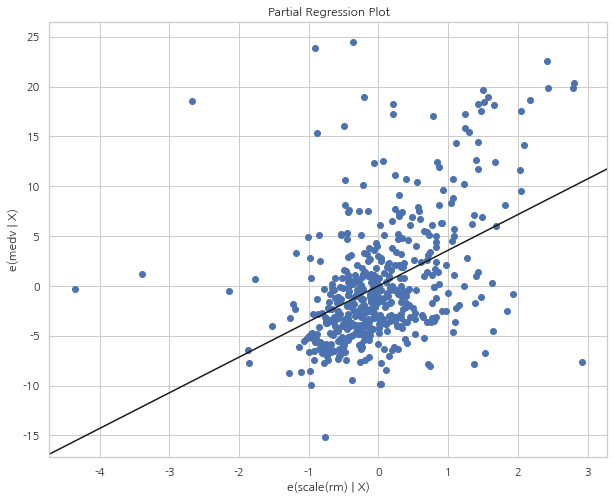

In [6]:
f, ax = plt.subplots(figsize=(10, 8))
sm.graphics.plot_partregress("medv", "scale(rm)", ["scale(lstat)"], boston,
                             obs_labels=False, ax=ax)
plt.show()

`plot_regress_exog` 함수를 이용하면 CCPR과 부분회귀 결과를 동시에 그릴 수 있다.

eval_env: 1


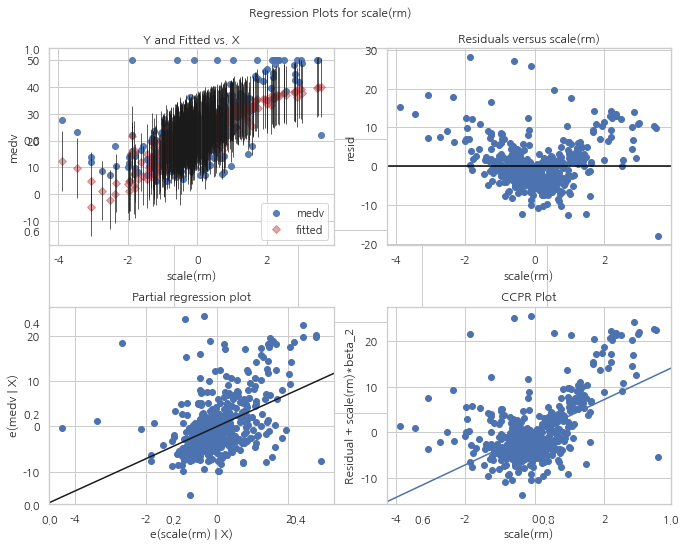

In [7]:
f, ax = plt.subplots(figsize=(10, 8))
sm.graphics.plot_regress_exog(result, "scale(rm)", fig=f)
plt.tight_layout()
plt.show()

상단 왼쪽의 그림은 우리가 처음에 그렸던 `plot_fit` 함수의 결과다. 하단은 부분회귀와 CCPR 결과다. 

`plot_regress_exog` 함수가 출력한 그림 중 상단 오른쪽의 그림은 <b>잔차플롯(residual plot)</b>이라고 하여 독립변수와 그에 대응하는 잔차의 값을 그린 것이다.

## 잔차분석

잔차를 분석하는 이유는 우리가 만든 선형회귀분석 모형이 정상적인 모형인지 아닌지를 검증하기 위한 것이다. 만약 우리가 사용한 모형과 데이터가 선형회귀분석에 사용되는 기본적인 확률론적 가정을 만족한다면 잔차는 평균이 0이고 분산이 고정된 정규분포를 따라야 한다. 

회귀분석 결과 요약에서 하단에 있는 부분이 잔차의 정규분포에 대한 통계치 및 정규성 검정 결과다.

```
Omnibus:                      145.712   
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              457.690
Skew:                           1.343   Prob(JB):                    4.11e-100
Kurtosis:                       6.807   
```

각 항목의 의미는 다음과 같다.

* `Skew` : 잔차분포의 왜도(skewness)
* `Kurtosis` : 잔차분포의 첨도(kurtosis)
* `Omnibus` : 옴니버스 정규성 검정의 통계치
* `Prob(Omnibus)` : 옴니버스 정규성 검정의 유의확률
* `Jarque-Bera (JB)` : 자끄베라 정규성 검정의 통계치
* `Prob(JB)` : 자끄베라 정규성 검정의 유의확률

우리가 사용한 예제에서는 정규성 검정결과로 나온 유의확률이 0에 가까운 값이므로 정규성 검정을 통과하지 못했다. 즉 모형의 기본 가정을 만족하지 않는다. 잔차가 정규성을 만족하지 못했다는 것은 가중치의 유의확률이나 신뢰구간 등의 분석결과에 오차가 있을 수 있다는 것을 뜻한다. 따라서 원칙적으로는 정규성 분포를 만족할 때까지 아웃라이어를 제거하거나 모형을 수정할 필요가 있다. 

그러나 현실적으로 데이터의 개수가 충분한 경우 (15개 이상), 잔차의 비정규성이 분석결과에 큰 영향을 미치는 경우는 드물고 대부분의 문제에서는 비실용적일 정도로 복잡한 모형이 아닌 한 정규성 검정읕 통과하지 못하는 경우가 많다. 정규성 검정의 중요성에 대해서는 아직도 통계학자들 사이에서 논란이 되고 있는 부분이지만 이 책에서는 일단 이 부분을 크게 신경쓰지 않고 넘어가기로 한다.

선형회귀에서 실질적으로 정규성보다 더 중요한 잔차의 성질은 다음 성질이다.

```{admonition} 잔차의 조건부 평균
선형회귀분석으로 나온 $N$개의 잔차 $e$에 대해서 기댓값은 독립변수와 상관없이 항상 0이다.

$$
\text{E}\left[ e | x \right] = 0
$$
```

우리가 만든 예제에 대해 이 성질이 성립하는지 시각적으로 확인하기 위해 독립변수와 잔차의 관계를 나타내는 잔차플롯을 그려보자. statsmodels 패키지에는 잔차플롯만 그리는 함수가 없으므로 잔차플롯만 그리고 싶을 때는 저자가 만든 다음 코드를 사용한다. 이 잔차플롯에서 파란색 곡선은 독립변수의 변화에 따른 잔차의 평균값을 표시한 것이다.

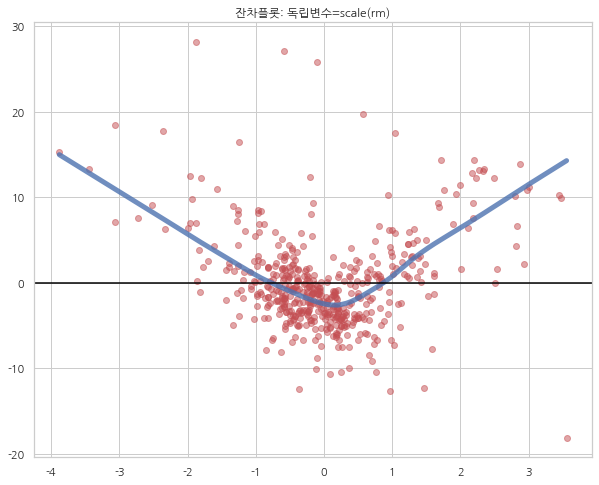

In [8]:
def resid_plot(result, exo_name):
    id_x = result.model.exog_names.index(exo_name)
    x = result.model.exog[:, id_x]
    r = result.resid
    l = sm.nonparametric.lowess(r, x)

    f, ax = plt.subplots(figsize=(10, 8))
    plt.scatter(x, r, c="r", alpha=0.5)
    plt.plot(l[:, 0], l[:, 1], lw=5, alpha=0.8)
    plt.axhline(y=0, color='black')
    plt.title(f"잔차플롯: 독립변수={exo_name}")

resid_plot(result, "scale(rm)")
plt.show()

잔차 평균이 독립변수와 관계없이 0이 되려면 잔차플롯에서 푸른 곡선이 y=0 에 해당하는 평평한 직선이어야 한다. 그러나 독립변수 rm과 잔차의 관계를 보면 첫번째 결과를 만족하지 않고 rm 값이 너무 작거나 너무 커지면 잔차의 값이 양의 방향으로 증가하는 것을 볼 수 있다. lstat 독립변수에 대해 잔차플롯을 그려도 비슷한 현상이 발생한다.

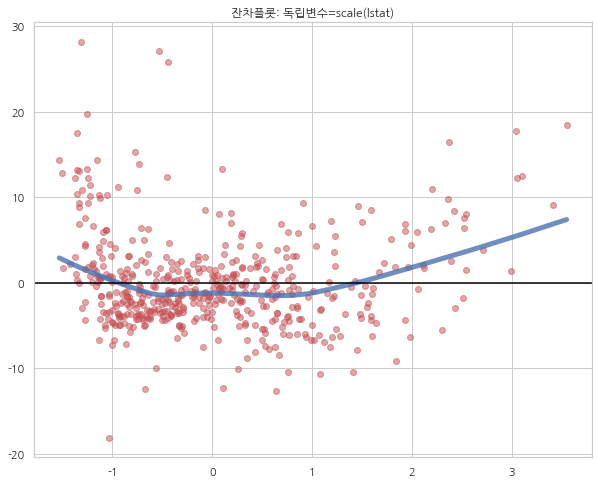

In [9]:
resid_plot(result, "scale(lstat)")

## 다항회귀

위와 같은 현상이 발생하는 원인은 우리가 생각한 선형회귀모형이 데이터에 맞지 않기 때문이다. 즉 데이터가 다음과 같은 선형관계를 따르지 않는다

$$
y = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_K x_K + \varepsilon 
$$

따라서 선형모형을 확장한 비선형 모형을 사용해야한다. 그런데 일반적인 비선형모형을 사용하면 지금까지 우리가 공부한 선형회귀분석을 활용할 수 없기 때문에 다음과 같은 비선형모형을 사용하는 것이 좋다.

$$
y = w_0 + w_1 f_1(x_1, x_2, \ldots, x_K) + w_2 f_2(x_1, x_2, \ldots, x_K) + \cdots + w_L f_L(x_1, x_2, \ldots, x_K) + \varepsilon 
$$

이 식에서 $f_l()$은 독립변수 $x_1, x_2, \ldots, x_K$를 입력으로 가지는 비선형함수들이다.  

이 모형은 다음과 같이 표시할 수도 있다.

$$
y = w_0 + w_1 x'_1 + w_2 x'_2 + \cdots + w_L x'_L + \varepsilon 
$$

즉 기존에 우리가 사용한 독립변수 $x_1, x_2, \ldots, x_K$를 비선형 변환한 값을 새로운 독립변수 $x'_1, x'_2, \ldots, x'_L$로 사용하는 것이다. 이 때 비선형함수는 자유롭게 지정할 수 있기 때문에 새로운 독립변수의 개수 $L$는 기존의 독립변수의 개수 $K$보다 훨씬 많아질 수 있다. 

이 방식을 사용하면 실질적으로는 비선형 함수를 사용하면서 우리가 지금까지 공부한 선형회귀분석을 활용할 수 있다.

이 때 비선형함수 $f_l()$를 만드는 방법은 데이터 분석가의 마음대로지만 가장 간단한 방법은 개별독립변수의 고차항 $x^2, x^3, x^4, \ldots$를 사용하는 방법이다. 예를 들어 독립변수가 하나뿐인 경우 회귀모형은 다음과 같아진다.

$$
y = w_0 + w_1 x + w_2 x^2 +  + w_3 x^3 \cdots + w_L x^L + \varepsilon 
$$

이 방법을 <b>다항회귀(polynomial regression)</b>이라고 한다.

statsmodels 패키지에서 다항회귀를 하려면 모형 문자열에 거듭제곱을 나타내는 `**` 연산과 `I()` 연산을 사용하여 독립변수를 추가한다.

```
formula = "y ~ x + I(x**2) + I(x**3) + I(x**4) + I(x**5)"
```

만약 `I()` 연산을 하지 않으면 나중에 설명할 상호작용(interaction) 항이 추가되어 다른 모형이 되므로 주의해야 한다.

예제로 사용한 보스턴 집값 분석에서 rm과 lstat의 2차항을 추가하여 분석하면 다음과 같다.

In [10]:
formula2 = "medv ~ scale(lstat) + scale(rm)" \
    " + scale(I(lstat**2)) + scale(I(rm**2))"
model2 = sm.OLS.from_formula(formula2, boston)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     377.7
Date:                Wed, 03 Aug 2022   Prob (F-statistic):          1.09e-149
Time:                        15:17:43   Log-Likelihood:                -1488.5
No. Observations:                 506   AIC:                             2987.
Df Residuals:                     501   BIC:                             3008.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               22.5328 

일단 가중치의 유의확률로 볼 때 모든 독립변수가 유의하고 결정계수 성능은 증가한 것을 알 수 있다.

잔차플롯을 그려보면 잔차의 평균이 앞의 모형보다 0에 더 가까운 형태로 개선되었다.

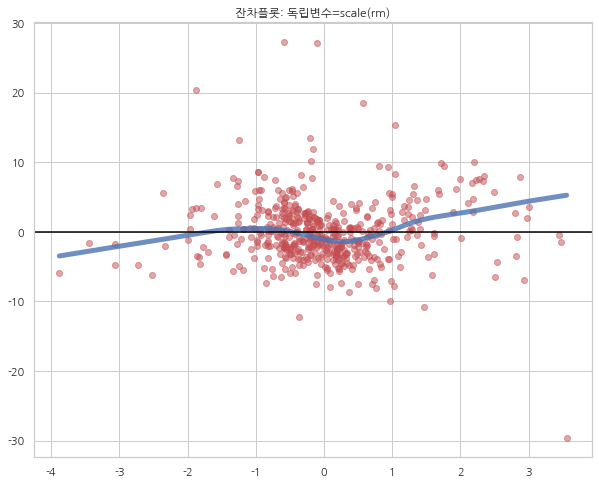

In [11]:
resid_plot(result2, "scale(rm)")

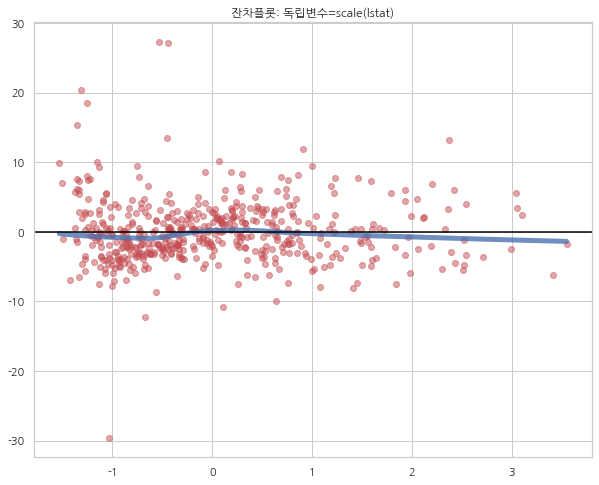

In [12]:
resid_plot(result2, "scale(lstat)")